# Thermal Hydraulics

The thermal hydraulics package is a powerful class that can calculate many different values from core temperatures to DNBR and CHF values.  To begin, several different types of data can be input.  Here is an example set of data below.  The program automatically calculates densities, viscosities, specific heats, etc. 

In [1]:
import NuclearTools.ThermalHydraulics as th
import pint
import pandas as pd
U = pint.UnitRegistry()

obj = th.reactor_thermals(
        power=3914*U.MW,
        height=150*U.inch,
        pitch=0.506*U.inch,
        T_inf=(556+458.67)*U.degR,
        Fq=2.34,
        Fx=1.5,
        D_clad=0.382*U.inch,
        D_pellet=.3255*U.inch,
        c_thick=0.025*U.inch,
        k_c=9.6*U.Btu/(U.hour*U.feet*U.rankine),
        n_rods=56876,
        hg=1000*U.Btu/(U.hour*U.feet**2*U.rankine),
        pressure=2250*U.psi,
        G=2.65*10**6*U.lb/(U.hour*U.feet**2),
        gamma=0.974,
        U=U,
        channel='hot',
        method='thom',
        life = 'MOC')

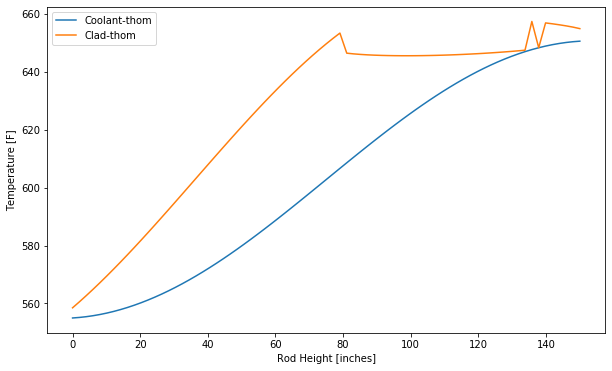

In [2]:
obj.plot(coolant=True, clad=True, units=U.degF, method=['thom'])

This plot is clearly not right for clad Temperature and this will usually come from a wrong guess in the mixed boiling region.  The automatic guess was too small so lets change our guess to a larger value (in degrees Rankine) and try again, this time with more methods of finding temperature in the mixed region.  The plotting for certain correlations can take significant amounts of time, especially for the chen correlation due to numerous transcendental solves per core height location.

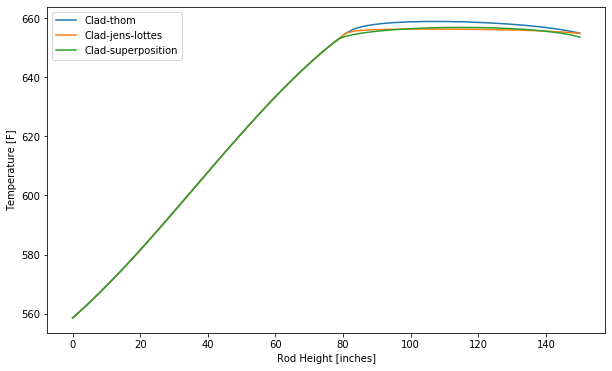

In [3]:
obj.T_mixed_guess = 1200
obj.plot(clad=True, units=U.degF, method=['thom', 'jens-lottes', 'superposition'])

Below we can also find several imporant values of the reactor core.

In [4]:
print('The saturation point of the clad is:', obj.T_clad_sat_location())
print('The incipient boiling point is:', obj.zn)
print('The fully developed nucleate boiling point is:', obj.zb)
print('The fluid sat. location is:', obj.T_coolant_sat_location())

The saturation point of the clad is: 78.35049069357649 inch
The incipient boiling point is: 80.60587110511418 inch
The fully developed nucleate boiling point is: 138.87410641218506 inch
The fluid sat. location is: 153.76114650391614 inch


We can also find the max fuel and clad temperatures as well as their respective axial location.  This max temperature will be calculated from the most recently called method to find clad temperature such as 'thom' or 'jens-lottes'.

In [5]:
print('The max clad temperature is ',(obj.max_T_clad()[0]).to(U.degF), 
      ' at ',obj.max_T_clad()[1])
print('The max fuel temperature is ',(obj.max_T_fuel()[0]).to(U.degF), 
      ' at ',obj.max_T_fuel()[1])

The max clad temperature is  656.895759567445 degF  at  115 inch
The max fuel temperature is  3516.1639478378183 degF  at  76 inch


In [6]:
print('The minimum DNB ratio is:', obj.MDNBR()[0], 'at', obj.MDNBR()[1])

The minimum DNB ratio is: 2.6123610920129607 at 104.0 inch


One useful way to quickly view all parameters, calculated and input for this 'reactor system' is to copy and execute the below code.  No need to change anything except for the object name which is 'obj' here.

In [7]:
table = {}
for inst in obj.__dict__.keys():
    table[inst] = obj.__dict__[inst]
df = pd.DataFrame(data=[table])
df.reindex(sorted(df.columns), axis=1)
print(df.transpose()[0:46])
print(df.transpose()[46:])

                                                               0
Ax                                 0.14142755840439075 inch ** 2
CPR                                                         None
D_clad                                                0.382 inch
D_pellet                                             0.3255 inch
De                                      0.47139047140264956 inch
Fq                                                          2.34
Fx                                                           1.5
G                             2650000.0 pound / foot ** 2 / hour
T_inf                                    1014.6700000000001 degR
T_mixed_guess                                               1200
T_sat                                    1112.4182789554984 degR
U              <pint.registry.UnitRegistry object at 0x000001...
c_thick                                               0.025 inch
cp                         1.4343283809769076 btu / degR / pound
cp_f                     

# Critical Heat Flux

One of the more important abilities of this code is its ability to find CHF values.  An example reactor input is given below (notice the change of input parameters from above).  We can also work backwards with this code and given a maximum CPR value, find the power of the reactor.

In [8]:
obj = th.reactor_thermals(
        height=148*U.inch,
        pitch=0.640*U.inch,
        T_inf=(532+458.67)*U.degR,
        Fq=2.22,
        Fx=1.4,
        D_clad=0.493*U.inch,
        n_rods=45384,
        pressure=1040*U.psi,
        G=1.21*10**6*U.lb/(U.hour*U.feet**2),
        gamma=0.943,
        U=U,
        channel='hot',
        method='thom',
        life = 'Bottom',
        CPR = 1.2)

In [9]:
print('The H0 value is:', obj.find_h0())
print('The critical q is:', obj.q_crit())
print('The max power is:', obj.max_Q().to(U.MW))

The H0 value is: 11.353748292363962 inch
The critical q is: 230743.88245629397 btu / foot ** 2 / hour
The max power is: 3538.809494336955 megawatt


In [10]:
print('The exit critical quality is:', obj.crit_quality(148))
print('The exit quality is:', obj.abs_quality(148))
print('The void fraction of the real channel is:', obj.alpha_dix(148, type='real'))
print('The void fraction of the critical channel is:', obj.alpha_dix(148, type='critical'))

The exit critical quality is: 0.3924066888948108
The exit quality is: 0.32093113995311573
The void fraction of the real channel is: 0.8221169998246636 dimensionless
The void fraction of the critical channel is: 0.8530856538027443 dimensionless


In [11]:
print('The minimum CHF ratio is:', obj.MCHF()[0], 'at', obj.MCHF()[1])

The minimum CHF ratio is: 1.5487737775234505 at 102 inch


# Void Fractions

Void fractions can also be determined in the reactor by using the void_fractions class as seen below.  The intervals of the input indicate the volume fraction cutoffs for bubbly, bubbly slug, etc..

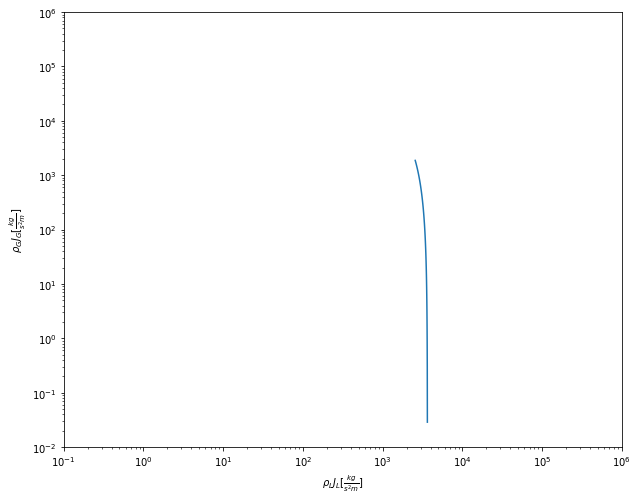

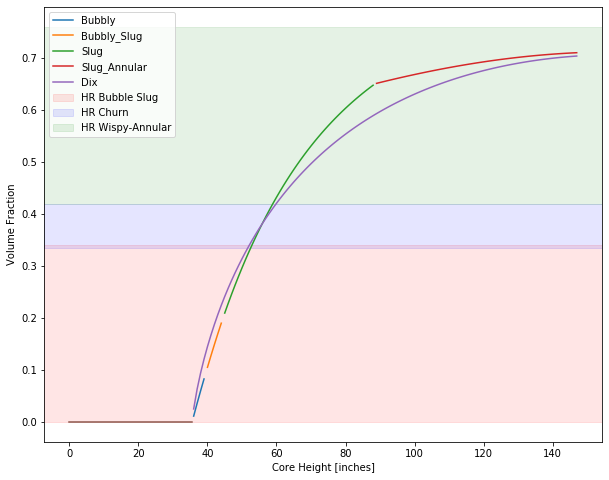

In [12]:
obj = th.void_fractions(heat_flux=144032*U.Btu/U.hour/U.foot**2,
             pressure=1040*U.psi,
             mass_flux=1.21*10**6 * U.lb/U.hour/U.foot**2,
             enthalpy=527.9*U.Btu/U.lb,
             height=148*U.inch,
             Fx=1.4,
             pitch=.64*U.inch,
             D_rod=.493*U.inch,
             U=U,
             intervals=(.1, .2, .65, .85, .9),
             life='MOC')
obj.plot_Hewitt_Roberts()
obj.plot()

To see all functionality of the code, do not forget about the help() command.

Ex: help(th)